# Financial Planning with APIs and Simulations

In this Challenge, you’ll create two financial analysis tools by using a single Jupyter notebook:

Part 1: A financial planner for emergencies. The members will be able to use this tool to visualize their current savings. The members can then determine if they have enough reserves for an emergency fund.

Part 2: A financial planner for retirement. This tool will forecast the performance of their retirement portfolio in 30 years. To do this, the tool will make an Alpaca API call via the Alpaca SDK to get historical price data for use in Monte Carlo simulations.

You’ll use the information from the Monte Carlo simulation to answer questions about the portfolio in your Jupyter notebook.



In [466]:
# Import the required libraries and dependencies
import os
import requests
import json

import pandas as pd
import alpaca_trade_api as tradeapi

from datetime import datetime
from dotenv   import load_dotenv

from monte_carlo_sim.MCForecastTools import MCSimulation
from monte_carlo_sim.alpaca.timezone import get_et_datetime

%matplotlib inline


In [467]:
yearly_trading_days = 252


In [468]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()


True

## Part 1: Create a Financial Planner for Emergencies

### Evaluate the Cryptocurrency Wallet by Using the Requests Library

In this section, you’ll determine the current value of a member’s cryptocurrency wallet. You’ll collect the current prices for the Bitcoin and Ethereum cryptocurrencies by using the Python Requests library. For the prototype, you’ll assume that the member holds the 1.2 Bitcoins (BTC) and 5.3 Ethereum coins (ETH). To do all this, complete the following steps:

1. Create a variable named `monthly_income`, and set its value to `12000`.

2. Use the Requests library to get the current price (in US dollars) of Bitcoin (BTC) and Ethereum (ETH) by using the API endpoints that the starter code supplies.

3. Navigate the JSON response object to access the current price of each coin, and store each in a variable.

    > **Hint** Note the specific identifier for each cryptocurrency in the API JSON response. The Bitcoin identifier is `1`, and the Ethereum identifier is `1027`.

4. Calculate the value, in US dollars, of the current amount of each cryptocurrency and of the entire cryptocurrency wallet.



In [469]:
def combine_shares_title_str(shares):    
    share_strs = [" ".join([f"{s:.1f}", t]) for t, s in shares.items()]
    share_strs = " and ".join(share_strs)
    
    return share_strs


def combine_coins_title_str(coins):    
    coin_strs = [" ".join([f"{s:.2f}", t]) for t, s in coins.items()]
    coin_strs = " and ".join(coin_strs)
    
    return coin_strs


def get_share_strs(coins, shares):
    share_strs = ""
    coin_strs  = ""
    if shares:
        share_strs += combine_shares_title_str(shares) + " shares"
        
    if coins:
        coin_strs  += combine_shares_title_str(coins)  + " coins"
        
    share_strs = ", \nand ".join(filter(None, [share_strs, coin_strs]))
    
    return share_strs


def closing_price_print(day, shares, title, value, portfolio):
    print(f"""
As of {day}, 
the closing price of the {portfolio}'s
{shares:.1f} {title} is {value:,.2f} USD.
    """)
    
    
def closing_value_print(day, shares, title, value, portfolio):
    print(f"""
As of {day}, 
the total value of the {portfolio}'s
{shares:.1f} {title} is {value:,.2f} USD.
    """)
    
    
def closing_portfolio_balance_print(day, value, portfolio, coins=None, shares=None):
    share_strs = get_share_strs(coins, shares)
    
    print(f"""
As of {day},
the total closing value of the {portfolio} containing 
{share_strs} 
is {value:,.2f} USD.
    """)
    
    
def cli_print(pct, portfolio, cli, coins=None, shares=None):
    share_strs = get_share_strs(coins, shares)

    print(f"""
The lower and upper {int(pct)}% confidence intervals 
of the {portfolio} containing 
{share_strs} 
is {cli[0]:,.2f} and {cli[1]:,.2f} USD.
    """)


In [483]:
class Investment():
    def __init__(self, ticker: str, name: str, count: float,
                 currency: str, portfolio: str, time_format: str):
        self.ticker          = ticker
        self.name            = name
        self.__count         = count
        self.currency        = currency
        self.portfolio       = portfolio
        self.time_format     = time_format
        self.__set_title()
        self.__set_id("")
        self.__set_collection_time(0)
        self.__set_price(0)
        self.__set_value(0)

    def __set_title(self):
        self.title = f"{self.name} ({self.ticker})"
    
    def __set_id(self, id: str):
        if id:
            self.id = id
        else:
            self.id = None
        
    def __set_collection_time(self, timestamp: datetime):
        if timestamp:
            self.collection_time = get_et_datetime(timestamp, self.time_format)
        else:
            self.collection_time = None
        
    def __set_price(self, price: float):
        if price:
            self.price = price
        else:
            self.price = None
            
    def __set_value(self, value: float):
        if value:
            self.value = value
        else:
            self.value = None
        
    def closing_price_print(self):
        closing_price_print(self.collection_time, 
                            self.__count, 
                            self.title, 
                            self.price, 
                            self.portfolio)
        
    def closing_value_print(self):
        closing_value_print(self.collection_time, 
                            self.__count, 
                            self.title, 
                            self.value, 
                            self.portfolio)
        
    @staticmethod
    def create_investment_dict(investments):
        if investments:
            if not isinstance(investments, list): investments = [investments,]
            investments = {inv.title: inv.__count  for inv in investments}
            
        return investments        
               
    @staticmethod
    def closing_portfolio_balance_print(collection_time,
                                        value,
                                        portfolio,
                                        coins=None,
                                        shares=None):        
        coins  = Investment.create_investment_dict(coins)
        shares = Investment.create_investment_dict(shares)
           
        closing_portfolio_balance_print(collection_time,
                                        value,
                                        portfolio,
                                        coins=coins,
                                        shares=shares)
        
    @staticmethod
    def cli_print(pct, portfolio, cli=list(), coins=None, shares=None):        
        coins  = Investment.create_investment_dict(coins)
        shares = Investment.create_investment_dict(shares)
           
        cli_print(pct, portfolio, cli, coins=coins, shares=shares)


In [471]:
class FreeCryptoResponse(Investment):
    def __init__(self, ticker: str, name: str, coins: float, currency: str):
        super().__init__(ticker,
                         name,
                         coins,
                         currency,
                         "cryptocurrency wallet",
                         "%a, %Y-%b-%d %H:%M:%S (%Z)")
        
        self.coins = coins
        self.set_response({})
        
    def set_response(self, response: dict):
        if response:
            self.response = response
            
            id        = list(response["data"].keys())[0]
            timestamp = datetime.fromtimestamp(response["metadata"]["timestamp"])
            price     = float(response["data"][id]["quotes"]["USD"]["price"])
            value     = self.coins * price
                
            self._Investment__set_id(id)            
            self._Investment__set_collection_time(timestamp)
            self._Investment__set_price(price)
            self._Investment__set_value(value)
        else:
            self.response = response


In [472]:
class AlpacaBarset(Investment):
    def __init__(self, ticker: str, name: str, shares: float, currency: str):
        super().__init__(ticker,
                         name,
                         shares,
                         currency,
                         "stock and bond portion of the portfolio",
                         "%a, %Y-%b-%d (%Z)")
        
        self.shares = shares
        self.set_response(pd.DataFrame())
        
    def set_response(self, response: pd.DataFrame):
        if not response.empty:
            self.response = response.loc[:, self.ticker]
            
            id        = ""
            timestamp = response.iloc[-1].name
            price     = response.loc[timestamp, (self.ticker, "close")]
            value     = self.shares * price
                
            self._Investment__set_id(id)
            self._Investment__set_collection_time(timestamp)
            self._Investment__set_price(price)
            self._Investment__set_value(value)
        else:
            self.response = response


In [473]:
# The current number of coins for each cryptocurrency asset held in the portfolio.
btc_coins = 1.2
eth_coins = 5.3
        

#### Step 1: Create a variable named `monthly_income`, and set its value to `12000`.

In [474]:
# The monthly amount for the member's household income
monthly_income = float(12000)

btc = FreeCryptoResponse("BTC", "Bitcoin",  btc_coins, "USD")
eth = FreeCryptoResponse("ETH", "Ethereum", eth_coins, "USD")

btc.__dict__


{'ticker': 'BTC',
 'name': 'Bitcoin',
 '_Investment__count': 1.2,
 'currency': 'USD',
 'portfolio': 'cryptocurrency wallet',
 'time_format': '%a, %Y-%b-%d %H:%M:%S (%Z)',
 'title': 'Bitcoin (BTC)',
 'id': None,
 'collection_time': None,
 'price': None,
 'value': None,
 'coins': 1.2,
 'response': {}}

#### Review the endpoint URLs for the API calls to Free Crypto API in order to get the current pricing information for both BTC and ETH.

In [475]:
# The Free Crypto API Call endpoint URLs for the held cryptocurrency assets
btc_url = f"https://api.alternative.me/v2/ticker/{btc.name}/?convert={btc.currency}"
eth_url = f"https://api.alternative.me/v2/ticker/{eth.name}/?convert={eth.currency}"


#### Step 2. Use the Requests library to get the current price (in US dollars) of Bitcoin (BTC) and Ethereum (ETH) by using the API endpoints that the starter code supplied.

In [476]:
# Using the Python requests library, make an API call to access the current price of BTC
btc_response = requests.get(btc_url).json()
btc.set_response(btc_response)

# Use the json.dumps function to review the response data from the API call
# Use the indent and sort_keys parameters to make the response object readable
print(json.dumps(btc_response, indent=4, sort_keys=True))


{
    "data": {
        "1": {
            "circulating_supply": 18764606,
            "id": 1,
            "last_updated": 1627067996,
            "max_supply": 21000000,
            "name": "Bitcoin",
            "quotes": {
                "USD": {
                    "market_cap": 604114393214,
                    "percent_change_1h": -0.0209038085472376,
                    "percent_change_24h": -0.383117981102021,
                    "percent_change_7d": 1.57278529013602,
                    "percentage_change_1h": -0.0209038085472376,
                    "percentage_change_24h": -0.383117981102021,
                    "percentage_change_7d": 1.57278529013602,
                    "price": 32225.0,
                    "volume_24h": 19319430174
                }
            },
            "rank": 1,
            "symbol": "BTC",
            "total_supply": 18764606,
            "website_slug": "bitcoin"
        }
    },
    "metadata": {
        "error": null,
        "num_cryptocur

In [477]:
# Using the Python requests library, make an API call to access the current price ETH
eth_response = requests.get(eth_url).json()
eth.set_response(eth_response)

# Use the json.dumps function to review the response data from the API call
# Use the indent and sort_keys parameters to make the response object readable
print(json.dumps(eth_response, indent=4, sort_keys=True))


{
    "data": {
        "1027": {
            "circulating_supply": 116812481,
            "id": 1027,
            "last_updated": 1627067992,
            "max_supply": 0,
            "name": "Ethereum",
            "quotes": {
                "USD": {
                    "market_cap": 235903931485,
                    "percent_change_1h": 0.263110758195359,
                    "percent_change_24h": -0.337207588610879,
                    "percent_change_7d": 5.78567848544544,
                    "percentage_change_1h": 0.263110758195359,
                    "percentage_change_24h": -0.337207588610879,
                    "percentage_change_7d": 5.78567848544544,
                    "price": 2021.28,
                    "volume_24h": 19280099398
                }
            },
            "rank": 2,
            "symbol": "ETH",
            "total_supply": 116812481,
            "website_slug": "ethereum"
        }
    },
    "metadata": {
        "error": null,
        "num_cryptocurr

#### Step 3: Navigate the JSON response object to access the current price of each coin, and store each in a variable.

In [478]:
# Navigate the BTC response object to access the current price of BTC
btc_price = float(btc.response["data"]["1"]["quotes"]["USD"]["price"])

# Print the current price of BTC
btc.closing_price_print()



As of Fri, 2021-Jul-23 15:19:56 (EDT), 
the closing price of the cryptocurrency wallet's
1.2 Bitcoin (BTC) is 32,225.00 USD.
    


In [479]:
# Navigate the BTC response object to access the current price of ETH
eth_price = float(eth_response["data"]["1027"]["quotes"]["USD"]["price"])

# Print the current price of ETH
eth.closing_price_print()



As of Fri, 2021-Jul-23 15:19:52 (EDT), 
the closing price of the cryptocurrency wallet's
5.3 Ethereum (ETH) is 2,021.28 USD.
    


### Step 4: Calculate the value, in US dollars, of the current amount of each cryptocurrency and of the entire cryptocurrency wallet.

In [480]:
# Compute the current value of the BTC holding 
btc_value = btc_coins * btc_price

# Print current value of your holding in BTC
btc.closing_value_print()



As of Fri, 2021-Jul-23 15:19:56 (EDT), 
the total value of the cryptocurrency wallet's
1.2 Bitcoin (BTC) is 38,670.00 USD.
    


In [481]:
# Compute the current value of the ETH holding 
eth_value = btc_coins * btc_price

# Print current value of your holding in ETH
eth.closing_value_print()



As of Fri, 2021-Jul-23 15:19:52 (EDT), 
the total value of the cryptocurrency wallet's
5.3 Ethereum (ETH) is 10,712.78 USD.
    


In [482]:
# Compute the total value of the cryptocurrency wallet
# Add the value of the BTC holding to the value of the ETH holding
total_crypto_wallet = btc_value + eth_value

# Print current cryptocurrency wallet balance
btc.closing_portfolio_balance_print(btc.collection_time,
                                    total_crypto_wallet,
                                    btc.portfolio,
                                    coins=[btc, eth])



As of Fri, 2021-Jul-23 15:19:56 (EDT),
the total closing value of the cryptocurrency wallet containing 
1.2 Bitcoin (BTC) and 5.3 Ethereum (ETH) coins 
is 77,340.00 USD.
    


### Evaluate the Stock and Bond Holdings by Using the Alpaca SDK

In this section, you’ll determine the current value of a member’s stock and bond holdings. You’ll make an API call to Alpaca via the Alpaca SDK to get the current closing prices of the SPDR S&P 500 ETF Trust (ticker: SPY) and of the iShares Core US Aggregate Bond ETF (ticker: AGG). For the prototype, assume that the member holds 110 shares of SPY, which represents the stock portion of their portfolio, and 200 shares of AGG, which represents the bond portion. To do all this, complete the following steps:

1. In the `Starter_Code` folder, create an environment file (`.env`) to store the values of your Alpaca API key and Alpaca secret key.

2. Set the variables for the Alpaca API and secret keys. Using the Alpaca SDK, create the Alpaca `tradeapi.REST` object. In this object, include the parameters for the Alpaca API key, the secret key, and the version number.

3. Set the following parameters for the Alpaca API call:

    - `tickers`: Use the tickers for the member’s stock and bond holdings.

    - `timeframe`: Use a time frame of one day.

    - `start_date` and `end_date`: Use the same date for these parameters, and format them with the date of the previous weekday (or `2020-08-07`). This is because you want the one closing price for the most-recent trading day.

4. Get the current closing prices for `SPY` and `AGG` by using the Alpaca `get_barset` function. Format the response as a Pandas DataFrame by including the `df` property at the end of the `get_barset` function.

5. Navigating the Alpaca response DataFrame, select the `SPY` and `AGG` closing prices, and store them as variables.

6. Calculate the value, in US dollars, of the current amount of shares in each of the stock and bond portions of the portfolio, and print the results.


#### Review the total number of shares held in both (SPY) and (AGG).

In [396]:
# Current amount of shares held in both the stock (SPY) and bond (AGG) portion of the portfolio.
spy_shares = 110
agg_shares = 200

spy = AlpacaBarset("SPY", "SPDR S&P 500 ETF Trust",              spy_shares, "USD")
agg = AlpacaBarset("AGG", "iShares Core US Aggregate Bond ETF",  agg_shares, "USD")


#### Step 1: In the `Starter_Code` folder, create an environment file (`.env`) to store the values of your Alpaca API key and Alpaca secret key.

#### Step 2: Set the variables for the Alpaca API and secret keys. Using the Alpaca SDK, create the Alpaca `tradeapi.REST` object. In this object, include the parameters for the Alpaca API key, the secret key, and the version number.

In [397]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key    = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2",
)


#### Step 3: Set the following parameters for the Alpaca API call:

- `tickers`: Use the tickers for the member’s stock and bond holdings.

- `timeframe`: Use a time frame of one day.

- `start_date` and `end_date`: Use the same date for these parameters, and format them with the date of the previous weekday (or `2020-08-07`). This is because you want the one closing price for the most-recent trading day.


In [398]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers = [spy.ticker, agg.ticker]

# Set timeframe to 1D 
timeframe = "1D"
timezone  = "America/New_York"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2020-08-07", tz=timezone).isoformat()
end_date   = pd.Timestamp("2020-08-07", tz=timezone).isoformat()


#### Step 4: Get the current closing prices for `SPY` and `AGG` by using the Alpaca `get_barset` function. Format the response as a Pandas DataFrame by including the `df` property at the end of the `get_barset` function.

In [399]:
# Use the Alpaca get_barset function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
closing_prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
).df

# Review the first 5 rows of the Alpaca DataFrame
closing_prices_df.head(5)


AGG                                        SPY  \
                             open    high      low    close   volume    open   
time                                                                           
2020-08-07 00:00:00-04:00  119.66  119.73  119.395  119.445  8830420  333.28   

                                                            
                             high    low   close    volume  
time                                                        
2020-08-07 00:00:00-04:00  334.88  332.3  334.55  98710236

#### Step 5: Navigating the Alpaca response DataFrame, select the `SPY` and `AGG` closing prices, and store them as variables.

In [400]:
agg.set_response(closing_prices_df)
spy.set_response(closing_prices_df)


In [401]:
# Access the closing price for AGG from the Alpaca DataFrame
# Converting the value to a floating point number
agg_close_price = float(closing_prices_df.loc["2020-08-07",("AGG","close")])

# Print the AGG closing price
agg.closing_price_print()



As of Fri, 2020-Aug-07 (EDT), 
the closing price of the stock and bond portion of the portfolio's
200.0 iShares Core US Aggregate Bond ETF (AGG) is 119.44 USD.
    


In [402]:
# Access the closing price for SPY from the Alpaca DataFrame
# Converting the value to a floating point number
spy_close_price = float(closing_prices_df.loc["2020-08-07",("SPY","close")])

# Print the SPY closing price
spy.closing_price_print()



As of Fri, 2020-Aug-07 (EDT), 
the closing price of the stock and bond portion of the portfolio's
110.0 SPDR S&P 500 ETF Trust (SPY) is 334.55 USD.
    


#### Step 6: Calculate the value, in US dollars, of the current amount of shares in each of the stock and bond portions of the portfolio, and print the results.

In [403]:
# Calculate the current value of the bond portion of the portfolio
agg_value = agg_shares * agg_close_price

# Print the current value of the bond portfolio
agg.closing_value_print()



As of Fri, 2020-Aug-07 (EDT), 
the total value of the stock and bond portion of the portfolio's
200.0 iShares Core US Aggregate Bond ETF (AGG) is 23,889.00 USD.
    


In [404]:
# Calculate the current value of the stock portion of the portfolio
spy_value = spy_shares * spy_close_price

# Print the current value of the stock portfolio
spy.closing_value_print()


As of Fri, 2020-Aug-07 (EDT), 
the total value of the stock and bond portion of the portfolio's
110.0 SPDR S&P 500 ETF Trust (SPY) is 36,800.50 USD.
    


In [405]:
# Calculate the total value of the stock and bond portion of the portfolio
total_stocks_bonds = agg_value + spy_value

# Print the current balance of the stock and bond portion of the portfolio
agg.closing_portfolio_balance_print(agg.collection_time,
                                    total_stocks_bonds,
                                    agg.portfolio,
                                    shares=[agg, spy])



As of Fri, 2020-Aug-07 (EDT),
the total closing value of the stock and bond portion of the portfolio containing 
200.0 iShares Core US Aggregate Bond ETF (AGG) and 110.0 SPDR S&P 500 ETF Trust (SPY) shares 
is 60,689.50 USD.
    


In [406]:
# Calculate the total value of the member's entire savings portfolio
# Add the value of the cryptocurrency walled to the value of the total stocks and bonds
total_portfolio = total_stocks_bonds + total_crypto_wallet

# Print current cryptocurrency wallet balance
agg.closing_portfolio_balance_print(btc.collection_time,
                                    total_portfolio,
                                    "total",
                                    coins=[btc, eth],
                                    shares=[spy, agg])



As of Fri, 2021-Jul-23 15:14:34 (EDT),
the total closing value of the total containing 
110.0 SPDR S&P 500 ETF Trust (SPY) and 200.0 iShares Core US Aggregate Bond ETF (AGG) shares, 
and 1.2 Bitcoin (BTC) and 5.3 Ethereum (ETH) coins 
is 137,979.10 USD.
    


### Evaluate the Emergency Fund

In this section, you’ll use the valuations for the cryptocurrency wallet and for the stock and bond portions of the portfolio to determine if the credit union member has enough savings to build an emergency fund into their financial plan. To do this, complete the following steps:

1. Create a Python list named `savings_data` that has two elements. The first element contains the total value of the cryptocurrency wallet. The second element contains the total value of the stock and bond portions of the portfolio.

2. Use the `savings_data` list to create a Pandas DataFrame named `savings_df`, and then display this DataFrame. The function to create the DataFrame should take the following three parameters:

    - `savings_data`: Use the list that you just created.

    - `columns`: Set this parameter equal to a Python list with a single value called `amount`.

    - `index`: Set this parameter equal to a Python list with the values of `crypto` and `stock/bond`.

3. Use the `savings_df` DataFrame to plot a pie chart that visualizes the composition of the member’s portfolio. The y-axis of the pie chart uses `amount`. Be sure to add a title.

4. Using Python, determine if the current portfolio has enough to create an emergency fund as part of the member’s financial plan. Ideally, an emergency fund should equal to three times the member’s monthly income. To do this, implement the following steps:

    1. Create a variable named `emergency_fund_value`, and set it equal to three times the value of the member’s `monthly_income` of $12000. (You set this earlier in Part 1).

    2. Create a series of three if statements to determine if the member’s total portfolio is large enough to fund the emergency portfolio:

        1. If the total portfolio value is greater than the emergency fund value, display a message congratulating the member for having enough money in this fund.

        2. Else if the total portfolio value is equal to the emergency fund value, display a message congratulating the member on reaching this important financial goal.

        3. Else the total portfolio is less than the emergency fund value, so display a message showing how many dollars away the member is from reaching the goal. (Subtract the total portfolio value from the emergency fund value.)


#### Step 1: Create a Python list named `savings_data` that has two elements. The first element contains the total value of the cryptocurrency wallet. The second element contains the total value of the stock and bond portions of the portfolio.

In [407]:
# Consolidate financial assets data into a Python list
savings_data = [total_crypto_wallet, total_stocks_bonds]

# Review the Python list savings_data
savings_data
    

[77289.59999999999, 60689.5]

#### Step 2: Use the `savings_data` list to create a Pandas DataFrame named `savings_df`, and then display this DataFrame. The function to create the DataFrame should take the following three parameters:

- `savings_data`: Use the list that you just created.

- `columns`: Set this parameter equal to a Python list with a single value called `amount`.

- `index`: Set this parameter equal to a Python list with the values of `crypto` and `stock/bond`.


In [408]:
# Create a Pandas DataFrame called savings_df 
savings_df = pd.DataFrame(data=savings_data, columns=["amount"], index=["crypto", "stock/bond"])

# Display the savings_df DataFrame
savings_df


,amount
crypto,77289.6
stock/bond,60689.5


#### Step 3: Use the `savings_df` DataFrame to plot a pie chart that visualizes the composition of the member’s portfolio. The y-axis of the pie chart uses `amount`. Be sure to add a title.

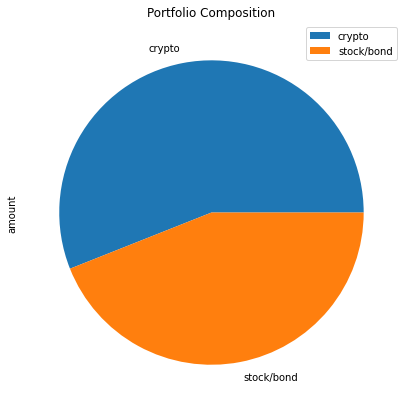

In [409]:
# Plot the total value of the member's portfolio (crypto and stock/bond) in a pie chart
savings_df.plot.pie(y="amount", title="Portfolio Composition", figsize=(15,7));


#### Step 4: Using Python, determine if the current portfolio has enough to create an emergency fund as part of the member’s financial plan. Ideally, an emergency fund should equal to three times the member’s monthly income. To do this, implement the following steps:

Step 1. Create a variable named `emergency_fund_value`, and set it equal to three times the value of the member’s `monthly_income` of 12000. (You set this earlier in Part 1).

Step 2. Create a series of three if statements to determine if the member’s total portfolio is large enough to fund the emergency portfolio:

* If the total portfolio value is greater than the emergency fund value, display a message congratulating the member for having enough money in this fund.

* Else if the total portfolio value is equal to the emergency fund value, display a message congratulating the member on reaching this important financial goal.

* Else the total portfolio is less than the emergency fund value, so display a message showing how many dollars away the member is from reaching the goal. (Subtract the total portfolio value from the emergency fund value.)


##### Step 4-1: Create a variable named `emergency_fund_value`, and set it equal to three times the value of the member’s `monthly_income` of 12000. (You set this earlier in Part 1).

In [410]:
# Create a variable named emergency_fund_value
emergency_fund_value = monthly_income * 3


##### Step 4-2: Create a series of three if statements to determine if the member’s total portfolio is large enough to fund the emergency portfolio:

* If the total portfolio value is greater than the emergency fund value, display a message congratulating the member for having enough money in this fund.

* Else if the total portfolio value is equal to the emergency fund value, display a message congratulating the member on reaching this important financial goal.

* Else the total portfolio is less than the emergency fund value, so display a message showing how many dollars away the member is from reaching the goal. (Subtract the total portfolio value from the emergency fund value.)

In [411]:
# Evaluate the possibility of creating an emergency fund with 3 conditions:
if total_portfolio > emergency_fund_value: 
    print("""
    Congratulations! You have enough money in this portfolio fund to fund your emergency fund!
    """)
elif total_portfolio == emergency_fund_value:
    print("""
    Congratulations! You now have enough money in this portfolio to fund your emergency fund!
    You have reached an important financial goal!
    """)
else:
    print(f"""
    You are {emergency_fund_value - total_portfolio:,.2f} USD away from being able to fund
    your emergency fund.
    """)



    Congratulations! You have enough money in this portfolio fund to fund your emergency fund!
    


## Part 2: Create a Financial Planner for Retirement

### Create the Monte Carlo Simulation

In this section, you’ll use the MCForecastTools library to create a Monte Carlo simulation for the member’s savings portfolio. To do this, complete the following steps:

1. Make an API call via the Alpaca SDK to get 3 years of historical closing prices for a traditional 60/40 portfolio split: 60% stocks (SPY) and 40% bonds (AGG).

2. Run a Monte Carlo simulation of 500 samples and 30 years for the 60/40 portfolio, and then plot the results.The following image shows the overlay line plot resulting from a simulation with these characteristics. However, because a random number generator is used to run each live Monte Carlo simulation, your image will differ slightly from this exact image:

![A screenshot depicts the resulting plot.](img/5-4-monte-carlo-line-plot.png)

3. Plot the probability distribution of the Monte Carlo simulation. Plot the probability distribution of the Monte Carlo simulation. The following image shows the histogram plot resulting from a simulation with these characteristics. However, because a random number generator is used to run each live Monte Carlo simulation, your image will differ slightly from this exact image:

![A screenshot depicts the histogram plot.](img/5-4-monte-carlo-histogram.png)

4. Generate the summary statistics for the Monte Carlo simulation.



#### Step 1: Make an API call via the Alpaca SDK to get 3 years of historical closing prices for a traditional 60/40 portfolio split: 60% stocks (SPY) and 40% bonds (AGG).

In [412]:
# Set start and end dates of 3 years back from your current date
# Alternatively, you can use an end date of 2020-08-07 and work 3 years back from that date
TZ = "America/New_York"
start_date = pd.Timestamp("2017-08-07", tz=TZ).isoformat()
end_date   = pd.Timestamp("2020-08-07", tz=TZ).isoformat()

# Set number of rows to 1000 to retrieve the maximum amount of rows
number_of_rows = 1000


In [413]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
price_data_df = alpaca.get_barset(
    tickers,
    timeframe,
    limit=number_of_rows,
    start=start_date,
    end=end_date
).df


# Display both the first and last five rows of the DataFrame
display(price_data_df.head(5))
display(price_data_df.tail(5))


AGG                                       \
                             open    high       low     close   volume   
time                                                                     
2017-08-07 00:00:00-04:00  109.69  109.72  109.6066  109.6850  1425317   
2017-08-08 00:00:00-04:00  109.67  109.69  109.5000  109.5810  1998999   
2017-08-09 00:00:00-04:00  109.87  109.87  109.6600  109.6700  2069028   
2017-08-10 00:00:00-04:00  109.70  109.85  109.6700  109.8053  1691677   
2017-08-11 00:00:00-04:00  109.75  109.94  109.6800  109.8850  1613467   

                              SPY                                     
                             open    high     low    close    volume  
time                                                                  
2017-08-07 00:00:00-04:00  247.49  247.87  247.37  247.850  20901988  
2017-08-08 00:00:00-04:00  247.51  248.91  246.83  247.291  44619069  
2017-08-09 00:00:00-04:00  246.47  247.31  246.06  247.230  48543032  
2017-08-10 00:00:00-04:00  246.28  246.44  243.70  243.790  87857827  
2017-08-11 00:00:00-04:00  244.02  244.80  243.75  244.110  56404847

AGG                                       \
                             open    high       low    close    volume   
time                                                                     
2020-08-03 00:00:00-04:00  119.37  119.40  119.1903  119.400  24615464   
2020-08-04 00:00:00-04:00  119.42  119.63  119.4200  119.630  21512268   
2020-08-05 00:00:00-04:00  119.39  119.49  119.3100  119.400  34239733   
2020-08-06 00:00:00-04:00  119.62  119.73  119.5300  119.580   9021388   
2020-08-07 00:00:00-04:00  119.66  119.73  119.3950  119.445   8830420   

                                SPY                                    
                               open    high     low   close    volume  
time                                                                   
2020-08-03 00:00:00-04:00  328.3200  329.62  327.73  328.76  89861354  
2020-08-04 00:00:00-04:00  327.8600  330.06  327.86  330.03  73684427  
2020-08-05 00:00:00-04:00  331.4700  332.39  331.18  332.06  72941562  
2020-08-06 00:00:00-04:00  331.4799  334.46  331.13  334.31  76988181  
2020-08-07 00:00:00-04:00  333.2800  334.88  332.30  334.55  98710236

#### Step 2: Run a Monte Carlo simulation of 500 samples and 30 years for the 60/40 portfolio, and then plot the results.

In [414]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
weights_dict = {spy.ticker: 0.60, agg.ticker: 0.40}
weights = [weights_dict[ticker] for ticker in price_data_df.columns.get_level_values(0).unique()]
weights

MC_thirty_year = MCSimulation(
    portfolio_data=price_data_df,
    weights=weights,
    num_simulation=500,
    num_trading_days=yearly_trading_days * 30
)

# Review the simulation input data
MC_thirty_year.portfolio_data.head()


AGG                                       \
                             open    high       low     close   volume   
time                                                                     
2017-08-07 00:00:00-04:00  109.69  109.72  109.6066  109.6850  1425317   
2017-08-08 00:00:00-04:00  109.67  109.69  109.5000  109.5810  1998999   
2017-08-09 00:00:00-04:00  109.87  109.87  109.6600  109.6700  2069028   
2017-08-10 00:00:00-04:00  109.70  109.85  109.6700  109.8053  1691677   
2017-08-11 00:00:00-04:00  109.75  109.94  109.6800  109.8850  1613467   

                                           SPY                           \
                          daily_return    open    high     low    close   
time                                                                      
2017-08-07 00:00:00-04:00          NaN  247.49  247.87  247.37  247.850   
2017-08-08 00:00:00-04:00    -0.000948  247.51  248.91  246.83  247.291   
2017-08-09 00:00:00-04:00     0.000812  246.47  247.31  246.06  247.230   
2017-08-10 00:00:00-04:00     0.001234  246.28  246.44  243.70  243.790   
2017-08-11 00:00:00-04:00     0.000726  244.02  244.80  243.75  244.110   

                                                  
                             volume daily_return  
time                                              
2017-08-07 00:00:00-04:00  20901988          NaN  
2017-08-08 00:00:00-04:00  44619069    -0.002255  
2017-08-09 00:00:00-04:00  48543032    -0.000247  
2017-08-10 00:00:00-04:00  87857827    -0.013914  
2017-08-11 00:00:00-04:00  56404847     0.001313

In [415]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007831,1.005069,0.997873,0.993231,0.988608,1.000554,0.991955,0.998366,1.015571,0.996777,...,0.999234,0.998474,1.000744,0.993962,1.007658,1.003724,1.003040,0.994959,1.004604,1.012867
2,1.013543,1.003134,0.990768,0.983595,0.999325,0.997580,0.980094,1.001610,1.005979,1.002501,...,1.004507,0.977515,0.985713,0.999513,1.016999,1.006796,1.013649,0.994583,1.008859,1.015388
3,1.013610,1.007499,1.003467,0.985241,1.004114,0.994394,0.988461,0.992970,1.001388,0.998643,...,1.008108,0.972350,0.991265,0.999442,1.011266,0.991593,1.008716,0.984286,0.994475,1.017493
4,1.009779,0.998105,1.004169,0.988494,1.020965,0.994010,0.976453,0.989747,1.006446,0.998285,...,1.013782,0.970790,0.993058,0.990633,1.012172,0.981237,1.011894,0.991994,1.003611,1.012823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,11.308742,7.958463,8.634739,11.887421,9.679373,45.710099,13.035390,34.014812,6.443249,13.927830,...,4.613796,24.027445,3.609736,2.672512,7.296747,9.110969,5.043655,2.896690,3.157540,10.963653
7557,11.253047,7.921957,8.632489,11.698098,9.742704,45.554413,12.972450,33.913246,6.407935,13.980154,...,4.633560,24.048503,3.592906,2.686234,7.220469,9.135157,5.095722,2.930902,3.096927,11.056921
7558,11.210782,7.968169,8.713335,11.897871,9.695677,45.189610,12.936398,33.721053,6.420134,13.967417,...,4.679623,24.195818,3.586302,2.658722,7.269309,9.128554,5.032930,2.892724,3.170368,11.136006
7559,11.275913,7.981918,8.693182,11.867206,9.712516,45.678613,12.786216,34.022323,6.457932,14.074337,...,4.677864,23.979400,3.618362,2.678587,7.302774,9.045156,5.009963,2.915367,3.172198,11.165579


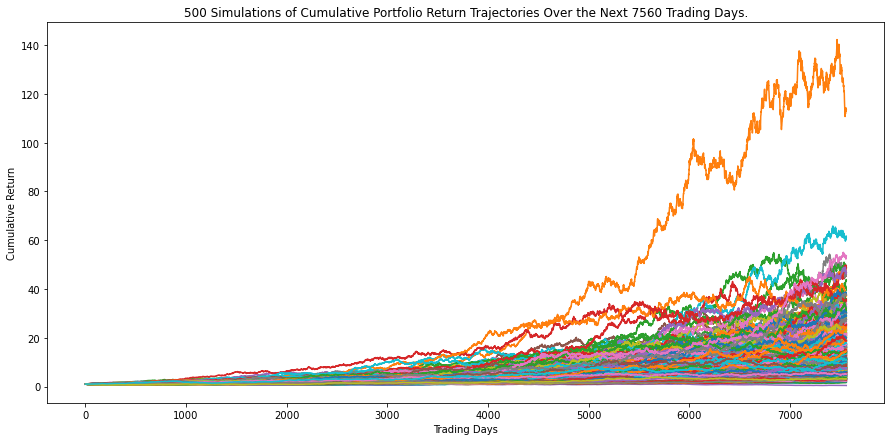

In [416]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
MC_thirty_year.plot_simulation(figsize=(15,7),
                               xlabel="Trading Days",
                               ylabel="Cumulative Return");


#### Step 3: Plot the probability distribution of the Monte Carlo simulation.

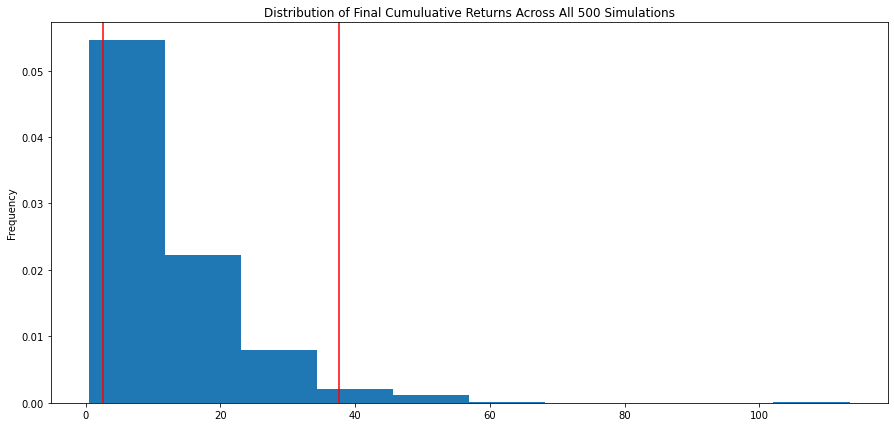

In [417]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
MC_thirty_year.plot_distribution(figsize=(15,7));


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [418]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_thirty_year_summary_stats = MC_thirty_year.summarize_cumulative_return()


# Review the 30-year Monte Carlo summary statistics
MC_thirty_year_summary_stats


count           500.000000
mean             12.881316
std              10.494241
min               0.440703
25%               6.186540
50%              10.076422
75%              15.882964
max             113.365131
95% CI Lower      2.617743
95% CI Upper     37.542930
Name: 7560, dtype: float64

### Analyze the Retirement Portfolio Forecasts

Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the Monte Carlo simulation, answer the following question in your Jupyter notebook:

-  What are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?


In [419]:
# Print the current balance of the stock and bond portion of the member's portfolio
spy.closing_portfolio_balance_print(
    spy.collection_time,
    total_stocks_bonds,
    spy.portfolio,
    shares=[spy, agg]
)



As of Fri, 2020-Aug-07 (EDT),
the total closing value of the stock and bond portion of the portfolio containing 
110.0 SPDR S&P 500 ETF Trust (SPY) and 200.0 iShares Core US Aggregate Bond ETF (AGG) shares 
is 60,689.50 USD.
    


In [420]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_thirty_cumulative_return = MC_summary_statistics.loc["95% CI Lower"] * total_stocks_bonds
ci_upper_thirty_cumulative_return = MC_summary_statistics.loc["95% CI Upper"] * total_stocks_bonds

# Print the result of your calculations
spy.cli_print("95",
              spy.portfolio,
              [ci_lower_thirty_cumulative_return,
               ci_upper_thirty_cumulative_return],
              shares=[spy, agg])



The lower and upper 95% confidence intervals 
of the stock and bond portion of the portfolio containing 
110.0 SPDR S&P 500 ETF Trust (SPY) and 200.0 iShares Core US Aggregate Bond ETF (AGG) shares 
is 131,490.81 and 2,648,544.99 USD.
    


### Forecast Cumulative Returns in 10 Years

The CTO of the credit union is impressed with your work on these planning tools but wonders if 30 years is a long time to wait until retirement. So, your next task is to adjust the retirement portfolio and run a new Monte Carlo simulation to find out if the changes will allow members to retire earlier.

For this new Monte Carlo simulation, do the following: 

- Forecast the cumulative returns for 10 years from now. Because of the shortened investment horizon (30 years to 10 years), the portfolio needs to invest more heavily in the riskier asset&mdash;that is, stock&mdash;to help accumulate wealth for retirement. 

- Adjust the weights of the retirement portfolio so that the composition for the Monte Carlo simulation consists of 20% bonds and 80% stocks. 

- Run the simulation over 500 samples, and use the same data that the API call to Alpaca generated.

- Based on the new Monte Carlo simulation, answer the following questions in your Jupyter notebook:

    - Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the new Monte Carlo simulation, what are the lower and upper bounds for the expected value of the portfolio (with the new weights) with a 95% confidence interval?

    - Will weighting the portfolio more heavily toward stocks allow the credit union members to retire after only 10 years?


In [421]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split 20% to AGG and 80% to SPY.
# Run 500 samples.
weights_dict = {spy.ticker: 0.80, agg.ticker: 0.20}
weights = [weights_dict[ticker] for ticker in price_data_df.columns.get_level_values(0).unique()]
weights

MC_ten_year = MCSimulation(
    portfolio_data=price_data_df,
    weights=weights,
    num_simulation=500,
    num_trading_days=yearly_trading_days * 10,
)

# Review the simulation input data
display(MC_ten_year.portfolio_data.head())


AGG                                       \
                             open    high       low     close   volume   
time                                                                     
2017-08-07 00:00:00-04:00  109.69  109.72  109.6066  109.6850  1425317   
2017-08-08 00:00:00-04:00  109.67  109.69  109.5000  109.5810  1998999   
2017-08-09 00:00:00-04:00  109.87  109.87  109.6600  109.6700  2069028   
2017-08-10 00:00:00-04:00  109.70  109.85  109.6700  109.8053  1691677   
2017-08-11 00:00:00-04:00  109.75  109.94  109.6800  109.8850  1613467   

                                           SPY                           \
                          daily_return    open    high     low    close   
time                                                                      
2017-08-07 00:00:00-04:00          NaN  247.49  247.87  247.37  247.850   
2017-08-08 00:00:00-04:00    -0.000948  247.51  248.91  246.83  247.291   
2017-08-09 00:00:00-04:00     0.000812  246.47  247.31  246.06  247.230   
2017-08-10 00:00:00-04:00     0.001234  246.28  246.44  243.70  243.790   
2017-08-11 00:00:00-04:00     0.000726  244.02  244.80  243.75  244.110   

                                                  
                             volume daily_return  
time                                              
2017-08-07 00:00:00-04:00  20901988          NaN  
2017-08-08 00:00:00-04:00  44619069    -0.002255  
2017-08-09 00:00:00-04:00  48543032    -0.000247  
2017-08-10 00:00:00-04:00  87857827    -0.013914  
2017-08-11 00:00:00-04:00  56404847     0.001313

In [422]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.979226,1.005457,1.010827,1.006321,0.989606,0.990419,1.002719,0.974101,1.006514,0.998455,...,0.993211,1.021310,1.009702,0.973457,1.003549,0.996088,0.996073,0.987047,1.012962,1.005520
2,0.971808,1.002797,1.015860,1.014974,0.966547,0.999810,1.002885,0.981553,1.025681,0.986025,...,1.001353,1.029477,1.011754,0.986616,0.999964,1.015333,0.990723,0.980969,1.014645,0.995230
3,0.966850,1.018869,1.027845,1.038649,0.987931,0.998953,1.011410,0.985679,1.025753,0.980135,...,1.007824,1.028394,0.998401,0.991924,0.978044,1.024704,1.004248,0.968023,1.012687,0.985299
4,0.954815,1.009228,1.027920,1.043938,0.995711,0.997187,0.991831,0.986645,1.047279,0.999012,...,0.989043,1.022704,0.985918,0.977172,0.968185,1.006194,0.986381,0.947590,1.005383,0.976120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.084963,1.565147,1.338948,1.766244,2.371577,3.108669,4.775965,1.674520,1.932043,2.344712,...,2.779421,3.486526,2.628601,4.270378,2.199914,1.153967,2.953898,0.545786,4.074647,1.329884
2517,1.092899,1.561236,1.347357,1.778545,2.366585,3.128786,4.758400,1.679861,1.938946,2.387843,...,2.776648,3.453103,2.651569,4.248737,2.208799,1.162687,2.923837,0.545966,4.059687,1.358355
2518,1.077265,1.586328,1.324280,1.828425,2.398165,3.092933,4.643804,1.724333,1.964536,2.359386,...,2.748502,3.453483,2.673012,4.276619,2.250923,1.175349,2.922944,0.550855,4.047929,1.374670
2519,1.056035,1.582482,1.324292,1.829951,2.358004,3.095461,4.580968,1.742009,1.980021,2.362486,...,2.780913,3.393770,2.695995,4.266280,2.279571,1.172724,2.929682,0.553704,3.994999,1.389103


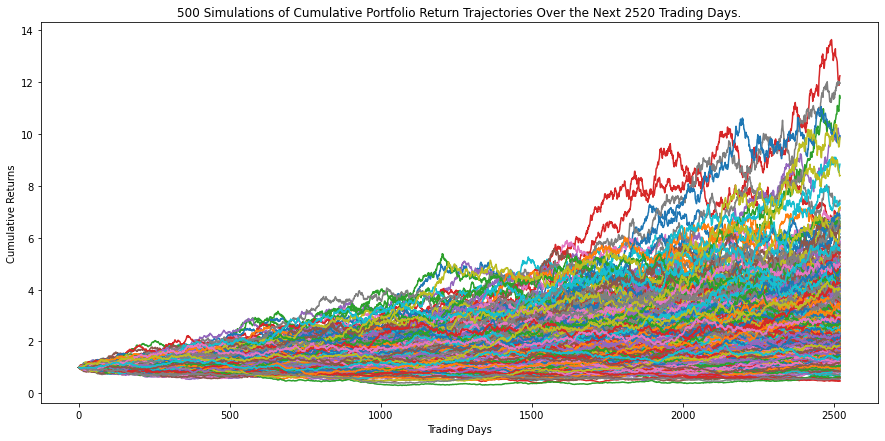

In [423]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
MC_ten_year.plot_simulation(figsize=(15,7),
                            xlabel="Trading Days",
                            ylabel="Cumulative Returns"
                           );


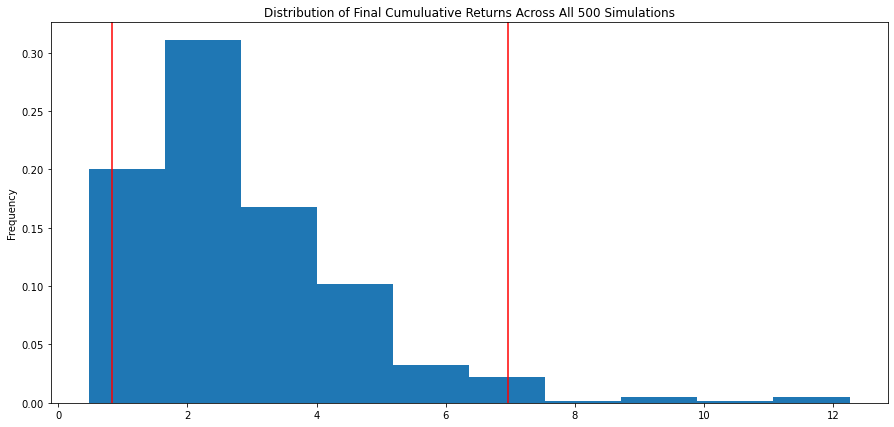

In [424]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
MC_ten_year.plot_distribution(figsize=(15,7));


In [425]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_ten_year_summary_stats = MC_ten_year.summarize_cumulative_return()

# Review the 10-year Monte Carlo summary statistics
MC_ten_year_summary_stats


count           500.000000
mean              2.839517
std               1.701656
min               0.468890
25%               1.687546
50%               2.491588
75%               3.577927
max              12.251357
95% CI Lower      0.833453
95% CI Upper      6.960412
Name: 2520, dtype: float64

### Answer the following questions:

#### Question: Using the current value of only the stock and bond portion of the member's portfolio and the summary statistics that you generated from the new Monte Carlo simulation, what are the lower and upper bounds for the expected value of the portfolio (with the new weights) with a 95% confidence interval?

In [426]:
# Print the current balance of the stock and bond portion of the members portfolio
spy.closing_portfolio_balance_print(
    spy.collection_time,
    total_stocks_bonds,
    spy.portfolio,
    shares=[spy, agg]
)



As of Fri, 2020-Aug-07 (EDT),
the total closing value of the stock and bond portion of the portfolio containing 
110.0 SPDR S&P 500 ETF Trust (SPY) and 200.0 iShares Core US Aggregate Bond ETF (AGG) shares 
is 60,689.50 USD.
    


In [427]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = MC_ten_year_summary_stats.loc["95% CI Lower"] * total_stocks_bonds
ci_upper_ten_cumulative_return = MC_ten_year_summary_stats.loc["95% CI Upper"] * total_stocks_bonds

# Print the result of your calculations
spy.cli_print("95",
              spy.portfolio,
              [ci_lower_ten_cumulative_return,
               ci_upper_ten_cumulative_return],
              shares=[spy, agg])



The lower and upper 95% confidence intervals 
of the stock and bond portion of the portfolio containing 
110.0 SPDR S&P 500 ETF Trust (SPY) and 200.0 iShares Core US Aggregate Bond ETF (AGG) shares 
is 50,581.87 and 422,423.89 USD.
    


#### Question: Will weighting the portfolio more heavily to stocks allow the credit union members to retire after only 10 years?